# DS3000 Final Project:  Lyft Price Prediction
## Team 0

- Aryan Shah (shah.ary@northeastern.edu)
- Thomas Nguyen (nguyen.thomas@northeastern.edu)
- Yu-Ting Ger (ger.y@northeastern.edu)
- Harmony Chan (chan.ha@northeastern.edu)

#### Reuse Permissions
The following may be re-used for any purposes:
- all data included with submission
- all images
- this and other jupyter notebooks
- the associated [video presentation](todo:addlink)

Please attribute any work to the authors listed above.

# Executive Summary
We built a model to predict prices of Lyft rides within Boston based on weather conditions of the pick-up location, the time when the ride request is made, and the total distance of the ride. We first used Random Forest Classifiers to determine if price buckets were significant enough and afterwards, used a multivariable polynomial regression model to predict a specific price of the lyft ride. Distance, ride type, and surge multiplier played the biggest role in affecting price in contrast to features such as temperature, weather, weekday, and hours that had little effect. Overall, our analysis does give some insight to potential lyft riders, but would not recommend using to try to convince a lyft rider to order a ride.

**Needs to be completed**

# Ethical Considerations

By knowing the effects of weather conditions and the time of ride request on the price of Lyft rides, consumers can take advantage of this knowledge and request a ride from Lyft only when the prices are lower. This could potentially harm Lyft drivers who are depending on price surges to increase their earnings. This tool may also be used by Lyft's competitors to come up with a specfic pricing algorithm against them. This can be done by setting their prices to be slightly lower than Lyft's so that consumers will be driven to their service. To address this, any use of this work should be open-source and approved by the developers to avoid unfair competitions.

# Introduction
Society has seen the recent rise of ride-sharing apps such as Lyft as they pull in more and more users.
This is due to the conveince of service, where people can get a quick ride just from a couple of taps on their phone.
However, there are times where rides are more expensive than normal or when availability is lower than expected. This begs a simple question: Why? More specfically, what exactly drives demand and prices? **This project aims to predict the price of Lyft rides in Boston based on weather conditions, ride distances, and time of ride request.**

# Data Description

(Full details of lyft data can be found in `lyft_clean.ipynb`, a summary of the relevant details is given here).

### Geocode 
First, we collect geocodes (latitude and longitude) of locations for lyft ride cost estimation from the [Position Stack API](https://positionstack.com/documentation). Provided a list of locations, the result is a dictionary mapping location names to geocode.

In [ ]:
import pandas as pd
df_geo = pd.read_csv('latlon.csv', index_col=0)

latlon_dict = dict()
for index, row in df_geo.iterrows():
    latlon_dict[index] = (row['lat'], row['lon'])

latlon_dict

{'Northeastern University': (42.339439, -71.087588),
 'Mission Hill': (42.333566, -71.102311),
 'Back Bay': (42.351838, -71.080507),
 'Fenway': (42.34947, -71.099199),
 'Lower Roxbury': (42.322451, -71.083092),
 'Kendall Square': (42.355492, -71.048611),
 'Chinatown': (42.35068, -71.06283),
 'Cambridge': (42.38036, -71.115987),
 'Brookline': (42.322764, -71.141356),
 'North End': (42.364354, -71.054749)}

### Lyft Ride Cost Estimation
Using the [Lyft API](https://www.lyft.com/developers/products/ride-request) we were able to request for estimated price cost at the current/immediate time instance by providing the latitude and longitude of the source and destination. 

In [ ]:
columns_list = ['date', 'hour', 'source', 'destination',
               'ride_type', 'distance_km', 'duration', 'price']

df_lyft = pd.read_csv('final_lyft_rides.csv')
df_lyft.loc[:, columns_list].head()

,date,hour,source,destination,ride_type,distance_km,duration,price
0,2021-04-18,21.0,Northeastern University,Mission Hill,Lyft,1.375127,7.95,9.0
1,2021-04-18,21.0,Northeastern University,Mission Hill,Lyft XL,1.375127,7.95,13.5
2,2021-04-18,21.0,Northeastern University,Mission Hill,Lux,1.375127,7.95,13.5
3,2021-04-18,21.0,Northeastern University,Mission Hill,Lux Black,1.375127,7.95,19.5
4,2021-04-18,21.0,Northeastern University,Mission Hill,Lux Black XL,1.375127,7.95,26.0


### Weather Data

Then we grab weather data from [Open Weather API](https://openweathermap.org/api) at the same time of the lyft ride cost estimation.

In [ ]:
weather_cols = ['date', 'hour', 'temp_fahren', 'weather', 
                'rain_volume_mm', 'snow_volume_mm']

df_lyft.loc[:, weather_cols].head()

,date,hour,temp_fahren,weather,rain_volume_mm,snow_volume_mm
0,2021-04-18,21.0,49.12,Clouds,0.0,0.0
1,2021-04-18,21.0,49.12,Clouds,0.0,0.0
2,2021-04-18,21.0,49.12,Clouds,0.0,0.0
3,2021-04-18,21.0,49.12,Clouds,0.0,0.0
4,2021-04-18,21.0,49.12,Clouds,0.0,0.0


### Kaggle Dataset

After running the pipeline to gather data, we figured that the correlations between price and other features weren't as interesting as expected. Therefore, we decided to use a [Kaggle dataset](https://www.kaggle.com/brllrb/uber-and-lyft-dataset-boston-ma) that collected data over a wider range of time and recorded similar features for lyft rides in December 2018 to cotinue with our analysis. The Kaggle dataset was cleaned and modified to include features that we are interested in and the full details can be found in `kaggle_clean_data.ipynb`.

In [ ]:
df_lyft_kaggle = pd.read_csv('lyft_rides.csv', index_col=0)
df_lyft_kaggle.head()

,destination,distance_km,hours,precip_intensity,precip_probability,price,ride_type,source,surge_multiplier,temp_fahren,weekday
0,North Station,0.44,9,0.0000,0.0,5.0,Shared,Haymarket Square,1.0,42.34,6
1,North Station,0.44,2,0.1299,1.0,11.0,Lux,Haymarket Square,1.0,43.58,1
2,North Station,0.44,1,0.0000,0.0,7.0,Lyft,Haymarket Square,1.0,38.33,2
3,North Station,0.44,4,0.0000,0.0,26.0,Lux Black XL,Haymarket Square,1.0,34.38,4
4,North Station,0.44,3,0.0000,0.0,9.0,Lyft XL,Haymarket Square,1.0,37.44,3


# Method

We have chosen ML tools and methods that would help best predict the price of a lyft ride, given a multitude of factors (both external and internal lyft features). The best way we thought going about this was to use ML classifiers to determine which features were the most significant in determine price of the lyft ride. From there, we would apply regression to estimate the price of the lyft ride.



### Converting ```price``` to a categorical variable

To classify the order of significance for each feature against price, we first categorized the price of a lyft ride into price buckets. This is imperative as the virtue of being a classifier signifies estimation of a categorical variable. As our target variable is price, we approximate binning by creating a price_bucket which lyft rides fall under. 


In [ ]:
def add_price_bucket(df_rideshare):
    """ converts price column to a price bucket range 
    
    Args:
        df_rideshare (DataFrame): DataFrame of lyft rides data
    """
    
    price_buckets = []
    
    for index, row in df_rideshare.iterrows():
        if row['price'] < 10:
            price_buckets.append('price < 10')
        elif row['price'] < 20:
            price_buckets.append('10 <= price < 20')
        elif row['price'] < 30:
            price_buckets.append('20 <= price < 30')
        else:
            price_buckets.append('price >= 30')
    
    df_rideshare['price_bucket'] = price_buckets
    
    del df_rideshare['price']

### Normalization by Standard Deviation

A common problem like many ML models run into is the different input features having different variances.



In [ ]:
import pandas as pd

x_feat_list = ['distance_km', 'hours', 'precip_intensity', 'precip_probability', 
            'surge_multiplier', 'temp_fahren', 'weekday', 'ride_type_Lux',
              'ride_type_Lux Black', 'ride_type_Lux Black XL', 'ride_type_Lyft', 
               'ride_type_Lyft XL', 'ride_type_Shared']

df_lyft = pd.read_csv('lyft_rides_numerical.csv')

df_lyft.loc[:, x_feat_list].var().sort_values()

precip_intensity           0.000719
surge_multiplier           0.018390
precip_probability         0.107665
ride_type_Shared           0.138886
ride_type_Lux Black XL     0.138890
ride_type_Lux Black        0.138890
ride_type_Lux              0.138890
ride_type_Lyft XL          0.138890
ride_type_Lyft             0.138890
distance_km                1.180747
weekday                    4.229725
temp_fahren               45.298619
hours                     48.381126
dtype: float64

Therefore, to ensure that the output features have equal variances, we applied standard deviation to normalize the input features. This ensures each feature has unit variance. This also ensures accurate representation in classifying feature significance.

In [ ]:
def normalize_x_feat(df_rideshare, x_feat_list):
    """ normalizes the x features through standard deviation
    
    Args
        df_rideshare (DataFrame): DataFrame of lyft rides data
        x_feat_list (list): list of x features that are used to predict y
    """
    
    # normalizes scale
    for feat in x_feat_list:
        df_rideshare[feat] = df_rideshare[feat] / df_rideshare[feat].std()

## Classifiers
Classifiers are important in determining which feature is best used to determine the price of a lyft ride. Since there are many input features that are being used to predict price, we first needed to check if the input features are significant enough to estimate price. This will be especially useful in determining whether or not the input features are relevant to price before applying a regression as a predictor model. 

### Random Forest Classifier
We used random forest classifier to classify the significance of the input features against price. We chose Random Forest Classifier over Decision Trees or any other classifier as it is not only less prone to overfitting, it is most accurate in classifying the significance of the input features. Since we are assuming there are no major outlier samples or mislabeled samples in our dataset, we expect the Random Forest to not allow overfitting to occur. We are allowed to assume this as the Lyft API that has a column from its response (```is_valid_estimate```) which verifies if the price estimation is valid or not and using this column, we filtered the DataFrame out rows that were not a valid price estimate in ```lyft_clean.ipynb```. Using this classifier, we are then able to determine that the input features we chose were significant enough to apply a regression model on.

## Regression
Regression is perfect for providing estimation on price of the lyft rides, given input features that have been determined to be relevant. From the prior ML tools that help classify how signifcant the lyft features are with the price buckets, regression would provide a predictive model with those determined significant features. This would give lyft users to have further insight from not only which factors they can keep in mind when estimating a lyft ride price, but also a rough estimation of how those features determine the calcuation of that price.

### Multivariable Polynomial Regression
Multivariable Polynomial Regression (MPR) is a regression model that is constructed from multidimensional data (multiple independent variables) to calculate the dependent variable (and in our case, the cost of a lyft rideshare). We chose this method as it allows us to test more than one x input feature against price as well the polynomial degree that best fits our data. We would perform MPR on different number of polynomial degrees to determine which degree best produces an accurate r^2 value without overfitting. Then, using MPR with the chosen degree, we cross-validated its r^2 value to determine the accuracy of the model. If the accuracy is high enough, we can then conclude that the given input features can be used to help estimate the price of a lyft ride to an extent. MPR is also helpful as it allows the user to know which input feature has more significance in impacting the price of the lyft ride compared to the others. This would allow people to take into consideration different weights that each input feature carries. However, one small limitation is that this regression model does not take into consideration outliers that could have affected the accuracy of the model. This also does not take into consideration other potential factors like seasonal change or one-off events (a very popular concert can lead to price being jacked up at the given time and place). However, we believe that this is acceptable enough for Boston residents to roughly estimate the cost of their lyft ride on a normal day.

# Results
Apply the ML method(s) of your choice and graph results.  Be sure to explain the meaning of the graph in simple terms while avoiding interpreting the result in the context of the application just yet.  Please include:
- At least one graph of your ML results.  All graphs should be “self-contained” in that the title, axis labels, legend, caption or other graph elements are sufficient to understand the meaning of the graph without referring to the text of the document.  
- Beautiful software which is clearly documented and elegantly implemented

### Random Forest Classifier - Sanity Check and Feature Importance

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

def feature_importance_from_rf(df_lyft_buckets, x_feat_list, y_feat):
    '''
    Use a random forests classfier in order to gain an insight into
    the importance of each feature(based on gini importance) in the lyft dataset(x_feat_list) 
    in predicting the price bucket(y_feat) of a lyft ride.
    
    Args:
        df_lyft_buckets (DataFrame): A pandas df with the lyft ride data and an additional
            column that categorises a ride into a price bucket
        x_feat_list (list): A list of features to be used to fit the Random Forests model
        y_feat (String): The column to predict
    
    Returns:
        rf_clf (RandomForestClassifier): The fitted Random Forests Classifier
        feat_importances (numpy array): The feature importance of every feature the model was trained on
    '''
    # Extract the x and y features for every row as numpy arrays 
    x = df_lyft_buckets.loc[:, x_feat_list].values
    y = df_lyft_buckets.loc[:, y_feat].values
    
    # Fit the Random Forest Regressor
    rf_clf = RandomForestClassifier()
    rf_clf.fit(x, y)
    
    # Get the feature importance(optimised reduction in gini impurity)
    feat_importances = rf_clf.feature_importances_
    
    return rf_clf, feat_importances

def cross_validate_rf(df_lyft_buckets, x_feat_list, y_feat):
    '''
    Use the 10 fold cross validation to compute the accracy of a Random Forests classfier 
    predicting the price bucket(y) of a lyft ride based on the given feature list.
    
    Args:
        df_lyft_buckets (DataFrame): A pandas df with the lyft ride data and an additional
            column that categorises a ride into a price bucket
        x_feat_list (list): A list of features to be used to fit the Random Forests model
        y_feat (String): The column to predict
    
    Returns:
        rf_clf (RandomForestClassifier): The cross validated and trained Random Forests
            classifier
        y_true (numpy array): A numpy array with the true y_feat values
        y_pred (numpy array): A numpy array with the predicted y_feat values using the 10 fold
            cross validated RandomForests classifier
    '''
    # Extract the x and y features for every row as numpy arrays 
    x = df_lyft_buckets.loc[:, x_feat_list].values
    y_true = df_lyft_buckets.loc[:, y_feat].values
    rf_clf = RandomForestClassifier()

    # Perform stratified 10 fold cross validation
    skf = StratifiedKFold(n_splits=10)
    y_pred = np.empty_like(y_true)
    
    for train_idx, test_idx in skf.split(x, y_true):
        # Extract the training and testing data for the current fold
        train_x, train_y = x[train_idx, :], y_true[train_idx]
        test_x, test_y = x[test_idx, :], y_true[test_idx]

        # Train the model with the training data and then test it on the testing data
        rf_clf.fit(train_x, train_y)
        y_pred[test_idx] = rf_clf.predict(test_x)
    
    return rf_clf, y_true, y_pred

#### Accurancy of Random Forests in Predicting Price Buckets
Visualizing the confusion matrix to gain an insight into the accuracy of predicting lyft ride price buckets using a Random Forest classfier.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score

def plot_confusion_matrix(y_true, y_pred):
    '''
    Plot the confusion matrix given the predicted and true values of a feature.
    Compute the accuracy of the classifier from the matrix and add it to the title.
    
    Args:
        y_true (numpy array): The true values of a feature
        y_pred (numpy array): The predicted values of a feature
    
    Returns:
        conf_mat (2D numpy array): The confusion matrix visualized
    '''
    # Computing the confusion matrix and the accuracy of the model
    conf_mat = confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = compute_accuracy(conf_mat)

    # Displaying the confusion matrix
    conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_true))
    conf_mat_disp.plot()
    plt.title(f'Predicting lyft price buckets using Random Forests CLF: Acc = {accuracy:.2f}')
    plt.gcf().set_size_inches(10, 10)
    plt.show()
    
    return conf_mat

def compute_accuracy(conf_matrix):
    '''
    Computes the accuracy of a classifier based on the given
    confusion matrix(propotion of all samples correctly predicted).
    
    Args:
        conf_matrix (numpy 2D array): The confusion matrix used to compute 
            the accuracy of the classifier
    
    Returns:
        accuracy (float): The accuracy of a classifier based on the confusion
            matrix provided
    '''
    correct_predictions = np.diag(conf_matrix).sum()
    total_predictions = conf_matrix.sum()
    accuracy = correct_predictions / total_predictions
    return accuracy

In [ ]:
import pandas as pd

# Load cleaned and normalized lyft df with price buckets and init x_feat_list and y_feat
df_lyft_buckets = pd.read_csv('lyft_rides_numerical_with_price_buckets.csv', index_col=[0])
x_feat_list = ['distance_km', 'hours', 'precip_intensity', 'precip_probability', 'surge_multiplier', 
               'temp_fahren', 'weekday', 'ride_type_Lux', 'ride_type_Lux Black', 'ride_type_Lux Black XL', 
               'ride_type_Lyft', 'ride_type_Lyft XL', 'ride_type_Shared']
y_feat = 'price_bucket'

In [ ]:
# Perfrom 10-fold cross validation on the Random Forest classifier
rf_clf, y_true, y_pred = cross_validate_rf(df_lyft_buckets, x_feat_list, y_feat)

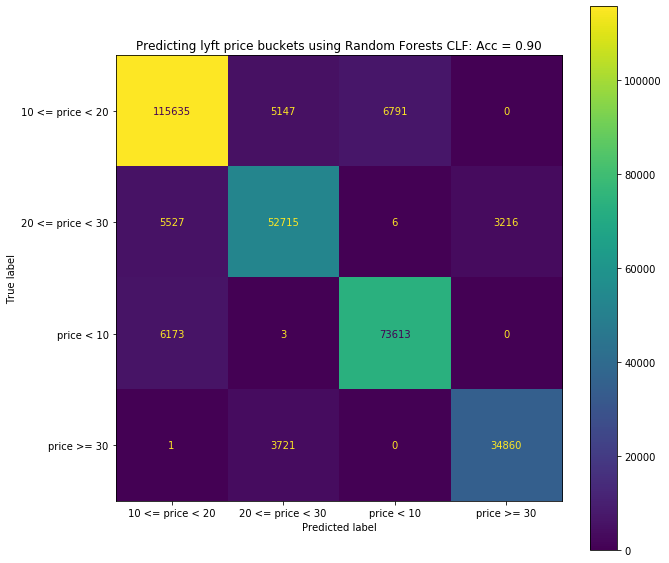

array([[115635,   5147,   6791,      0],
       [  5527,  52715,      6,   3216],
       [  6173,      3,  73613,      0],
       [     1,   3721,      0,  34860]])

In [ ]:
# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

From the confusion matrix, the accuracy of predicting lyft price buckets from our feature list is 0.90 and no bucket is easier or more difficult to predict. This gives us confidence in our features and allows us to move forward with regression.

#### Visualizing Feature Importance
To gain some insight into the importance of each of the features in our dataset in predicting the price, we are visualizing the feature importances provided by our cross validated Random Forests Classifier.

In [ ]:
# From HW07 starter code
import seaborn as sns
import matplotlib.pyplot as plt
def visualize_feature_importances(x_feat_list, feat_importances):
    '''
    Visualize the a Random Forest classifier's feature importance list as a bar chart.
    
    Args:
        x_feat_list (list): A list of features that were used in fitting the Random Forest
            classfier whose feature importance list is to be visualized
        feat_importances (numpy array): The feature importances of the features in 
            the given x_feat_list
    '''
    # Sort the features in descending order
    idx = np.argsort(feat_importances).astype(int)
    x_feat_list = [x_feat_list[_idx] for _idx in idx]
    feat_importances = feat_importances[idx] 
    
    # Plot the bar char
    plt.barh(x_feat_list, feat_importances)
    
    # Plot config
    plt.gcf().set_size_inches(10, len(x_feat_list) / 2)
    plt.title('Feature importance of lyft ride data in predicting price bucket')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
# Compute the feature importance
rf_clf, feat_importances = feature_importance_from_rf(df_lyft_buckets, x_feat_list, y_feat)

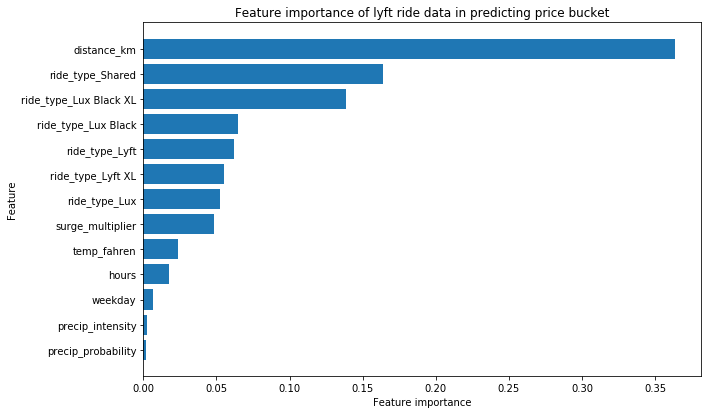

In [ ]:
# Plot the feature importance
visualize_feature_importances(x_feat_list, feat_importances)

From the above feature importance horizontal bar graph, weather indicators such as percipitation and temperature have little impact on a ride's price bucket as compared to the ride's duration, type and surge.

### Predicting Price - Multivariable Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

def multi_poly_fit(df_lyft, x_feat_list, y_feat, degree=1):
    '''
    Perform multi variable polynomial regression of the given degree to predict the given 
    y_feat using the provided list of features. Then, perform  10 fold cross validation to 
    compute the R^2 of the model as a measure of its accuracy.
    
    Args:
        df_lyft (DataFrame): A pandas df with the lyft ride data
        x_feat_list (list): A list of features to be used to fit the regression model
        y_feat (String): The column to predict
        degree (number): The degree of polynomial regression to use
    
    Returns:
        results (dictionary): The results containing the r2 of the cross validated
            model, along with the intercept and coefficients of the fitted model
    '''    
    # Extract the x and y columns
    x = df_lyft.loc[:, x_feat_list].values
    y_true = df_lyft.loc[:, y_feat].values
    
    # Compute the polynomial features and fit the model
    poly_feat = PolynomialFeatures(degree=degree, interaction_only=True)
    x_poly = poly_feat.fit_transform(x)
    reg = LinearRegression()
    reg.fit(x_poly, y_true)
    
    # Extract the model intercept and coefficients
    intercept = reg.intercept_
    coefs = reg.coef_

    # Perform 10 fold cross validation for the r2 value
    y_pred = np.empty_like(y_true)
    kf = KFold(n_splits=10)
    
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(x)):
        # Extract the training and testing data
        x_train, y_train = x[train_idx], y_true[train_idx]
        x_test, y_test = x[test_idx], y_true[test_idx]

        # Compute the polynomial features
        poly_feat = PolynomialFeatures(degree=degree, interaction_only=True)
        x_train_poly = poly_feat.fit_transform(x_train)

        # Perform linear regression on the polynomial features
        reg = LinearRegression()
        reg.fit(x_train_poly, y_train)

        # Predict the y values from the polynomial features
        x_test_poly = poly_feat.fit_transform(x_test)
        y_pred[test_idx] = reg.predict(x_test_poly)

    # Compute and return the r2
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    
    results = {
        'r2': r2,
        'intercept': intercept,
        'coefs': coefs
    }
    
    return results

In [ ]:
# Load the cleaned lyft data into a dataframe
df_lyft_reg = pd.read_csv('lyft_rides_numerical.csv', index_col=[0])

# The feature list to train the model on 
x_feat_list = ['distance_km', 'hours', 'precip_intensity', 'precip_probability', 'surge_multiplier', 
               'temp_fahren', 'weekday', 'ride_type_Lux', 'ride_type_Lux Black', 'ride_type_Lux Black XL', 
               'ride_type_Lyft', 'ride_type_Lyft XL', 'ride_type_Shared']
y_feat = 'price'

# Perform multi variable polynomial regression for degrees 1 to 3
reg_results_dict = {}
for degree in range(1, 4):
    results = multi_poly_fit(df_lyft_reg, x_feat_list, y_feat, degree=degree)
    reg_results_dict[f'degree {degree}'] = results

#### Displaying Results

In [ ]:
# Display the R^2s
r2s = list(map(lambda kv: (kv[0], kv[1]['r2']), reg_results_dict.items()))
print(r2s)

[('degree 1', 0.9364495514262896), ('degree 2', 0.9720914958597229), ('degree 3', 0.972400506610129)]


As seen above, there is no significant jump in R^2 between the different degrees of polynomial models, and hence the multivariable linear model can be chosen as an effective model for predicting the price. 

In [ ]:
# Display the equation for the degree 1 model
print('Price = ')
degree1_coefs = reg_results_dict['degree 1']['coefs']
degree1_intercept = reg_results_dict['degree 1']['intercept']

for idx, x_feat in enumerate(x_feat_list):
    print(f'{degree1_coefs[idx + 1]:.2f} * {x_feat} + ')
    
print(f'{degree1_intercept:.2f}')

Price = 
3.24 * distance_km + 
0.00 * hours + 
0.04 * precip_intensity + 
0.00 * precip_probability + 
18.19 * surge_multiplier + 
0.00 * temp_fahren + 
0.00 * weekday + 
0.31 * ride_type_Lux + 
5.60 * ride_type_Lux Black + 
14.87 * ride_type_Lux Black XL + 
-7.86 * ride_type_Lyft + 
-2.17 * ride_type_Lyft XL + 
-10.75 * ride_type_Shared + 
-8.52


# Discussion
 
To begin with, we used a random forest classifier to classify the significance of the input features and ensure that the accuracy of predicting lyft ride price buckets was significant enough.
 
When predicting the accuracy of predicting lyft price buckets, we gained insight on the importance of each feature to predict price bucket. From most important to least important:
- Distance in kilometers with a value of over 0.35. This result was expected where the further away a source is from its destination, the more expensive the trip.
- Ride type shared (or not) with a value of about 0.17. Again, this feature importance is expected where price would decrease if a rider shares a lyft ride with another.
- Car ride type (Lux Black XL, Lux Black, Lyft, Lyft XL, Lux) with values of about 0.07 and under. This is expected where a bigger lyft car size and/or a luxury vehicle would make price increase.
- Surge multiplier with a value of about 0.06. This value was a bit surprising, as a surge multiplier is pretty much a price multiplier and would think to have more importance. We suspect that distance, a shared ride, and car ride type has even more of an impact on price than surge multiplier.
- Temperature in fahrenheit with a value of about 0.025. The result was expected as we think temperature would have some sort of effect on price, but not as much as distance.
- Hours, or time of day with a value of 0.02. The value was not expected, where many would think for example finding a lyft ride at midnight would be more expensive than midday.
- Weekday, precipitation intensity, and precipitation probability with values less than 0.01. These results were unexpected where we would think weather and weekday would impact driver availability and rider demand and therefore affect price.
 
We then cross-validated our classifier, in which our accuracy computed to be 0.9, in which proved to be of importance to go ahead with utilizing a multivariable polynomial regression.
 
The regressions r-squared when put to the degree from 1 to 3 is above 0.93 and does not change much between the different degrees, meaning it is an effective model for predicting price and that at least 93% of the difference in price can be explained by the differences in the x features.
 
According to the equation When taking into consideration all features to predict price, surge multiplier and car ride type Lux Black XL are the most expensive features. For distance, every 1 kilometer traveled caused a price increase of 3.24. Having a ride shared caused the most decrease of price. Hours, weekday, temperature, and precipitation had little to no effect on price.
 
Overall, temperature, weather, weekday, and hours played little role on price than we initially thought which was unexpected. Ride type and distance made the biggest effect which was not surprising, but disappointing as these features seemed already obvious to most people. 
 
## Takeaway
 
After we conducted our analysis, and reached the conclusion that ride type and distance made more impact on price than any other features which we are confident about, we could additionally in the future find other features that could possibly have importance on the price, such as location. We could have built a more reliable and accurate pipeline with given time and resources, and would not have to rely on the Kaggle dataset that limited our scope of analysis and possibility affected the importance of some features like weather.
